# Buildingblocks of the model in theano

In [2]:
import numpy as np
import theano
import theano.tensor as tt
import pymc3 as pm

import matplotlib.pyplot as plt

theano.config.optimizer="None"


## Lognormal Distribution
(as taken from https://github.com/Priesemann-Group/covid19_inference_forecast)

In [3]:
def tt_lognormal(x, mu, sigma):
    x = tt.clip(x,1e-12,1e12) # Checks to improve stability and resilience against NANs
#    mu = tt.clip(mu,1e-12,1)
#    sigma = tt.clip(sigma,1e-12,1e12)
    
    distr = 1/x* tt.exp(-((tt.log(x) - mu) ** 2) / (2 * sigma ** 2))
    return distr / (tt.sum(distr, axis=0)+1e-9)

Elemwise{true_div,no_inplace}.0


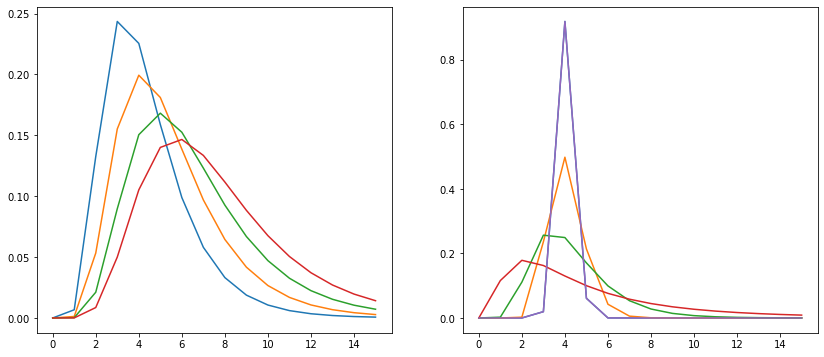

In [9]:
print(tt_lognormal(np.arange(10),4,.443))
d = tt.vector()
s_lognormal_median = tt.scalar()
s_lognormal_sigma = tt.scalar()

s_beta = tt_lognormal(d, tt.log(s_lognormal_median), s_lognormal_sigma)
f_beta = theano.function([d,s_lognormal_median,s_lognormal_sigma],[s_beta])

fig, axes = plt.subplots(1,2, figsize = (14,6),squeeze=False)
ax = axes[0,0]
for m in [4,5,6,7]:
    ax.plot(f_beta(np.arange(16),m,.443)[0])
bx = axes[0,1]
for s in [.1,.2,.4,.8,.1]:
    bx.plot(f_beta(np.arange(16),4,s)[0])

## S(I)R Model
* tt.roll right shifts the internal state by one
* tt_set_subtensor sets the first element of the internal state to the new (imported) cases.
No Infection is calculated

In [4]:
# Working model with shifting internal state instead of taps
# Theano symbolic Variables
d = tt.vector()
s_median_incubation = tt.scalar()
s_sigma_incubation = tt.scalar()

def SIR_model_noInfect(imported_t,l=16):
    s_imported_t = tt.vector()
    s_lambda_t = tt.vector()
    p_infected = tt.fvector("internal state")
    
    def imported_day_acc(imported_at_t,p_infected):
        new = imported_at_t
        p_infected = tt.roll(p_infected,1,0)
        p_infected = tt.set_subtensor(p_infected[:1],new,inplace=False)
        return p_infected
    
    outputs_info = [np.zeros(l)]
    infected_t,updates = theano.scan(fn=imported_day_acc,sequences=[s_imported_t],outputs_info=outputs_info)
    
    # Create a function using the symbolic expressions defined above
    calc_infected = theano.function(inputs=[s_imported_t],outputs=infected_t,updates=updates)
    # Run that function
    return calc_infected(imported_t)

In [5]:
imported_t = [0,1,2,3,0,0,0,0]
print("Last internal state",SIR_model_noInfect(imported_t)[-1] )

Last internal state [0. 0. 0. 0. 3. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## SIR Model
New infections are calculated on internal state (dot) lognormal infection - distribution

In [6]:
# Model that takes imported cases and holds internal state of new_infected on last l days. 
# new_infected = dot ( infected_of_last_days , beta_distr ) 
# sequences (if any), prior result(s) (if needed), non-sequences (if any)

# Theano symbolic Variables
d = tt.vector()
s_median_incubation = tt.scalar()
s_sigma_incubation = tt.scalar()

s_beta = tt_lognormal(d, tt.log(s_median_incubation), s_sigma_incubation)
f_beta = theano.function([d,s_median_incubation,s_sigma_incubation],[s_beta])

def SIR_model(imported_t,lambda_t, median_incubation,sigma_incubation,l=16):
    beta = f_beta(range(l),median_incubation,sigma_incubation)[0]
    
    s_imported_t = tt.vector()
    s_lambda_t = tt.vector()
    s_infected_t = tt.vector()
    p_infected = tt.dvector("internal state")
    
    def next_day(lambda_at_t,imported_at_t,p_infected,beta):
        new = imported_at_t + theano.dot(p_infected,beta) * lambda_at_t
        p_infected = tt.roll(p_infected,1,0)
        p_infected = tt.set_subtensor(p_infected[:1],new,inplace=False)
        return new,p_infected
    # Initial internal state
    outputs_info = [None,np.zeros(l)]
    infected_t,updates = theano.scan(fn=next_day,
                                     sequences=[s_lambda_t,s_imported_t],
                                     outputs_info=outputs_info,
                                     non_sequences=beta)
    # Create a function using the symbolic expressions defined above
    calc_infected = theano.function(inputs=[s_lambda_t,s_imported_t],outputs=infected_t,updates=updates)
    # Run that function
    newI,I = calc_infected(lambda_t,imported_t)
    return newI

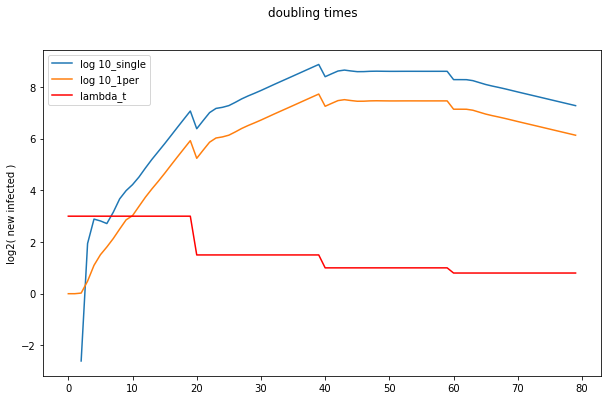

In [7]:
dur = 20
imported1_t = np.array( [10.]+[0.]*(dur*5-1) )
imported2_t = np.array( [1.]*10+[0.]*(dur*5-10) )

lambda_t = np.array( [3.]*dur+[1.5]*dur+[1]*dur+[.8]*dur )

median,sigma = 4.,0.433

# Test two different initial distributions
fig, axes = plt.subplots(1,1, figsize = (10,6),squeeze=False)
fig.suptitle("doubling times")

ax = axes[0,0]
for k,imp in {"10_single":imported1_t,"10_1per":imported2_t}.items():
    ax.plot( np.log(SIR_model(imp,lambda_t,median,sigma))/np.log(2),label="log "+k )
ax.plot(lambda_t,color="red",label="lambda_t")
ax.set_ylabel("log2( new infected )")
ax.legend()

## SEIR model
newly infected with factor *f* modelling exposed i.e. not immune
E_t counts exposed as internal state

In [8]:
# sequences (if any), prior result(s) (if needed), non-sequences (if any)
d = tt.vector()
s_median_incubation = tt.scalar()
s_sigma_incubation = tt.scalar()

s_beta = tt_lognormal(d, tt.log(s_median_incubation), s_sigma_incubation)
f_beta = theano.function([d,s_median_incubation,s_sigma_incubation],[s_beta])

def SIER_model(N, imported_t,lambda_t, median_incubation,sigma_incubation,l=16):
    N = tt.cast(N,'float64')
    beta = f_beta(range(l),median_incubation,sigma_incubation)[0]
  #  beta = beta/sum(beta)
    
    s_imported_t = tt.dvector()
    s_lambda_t = tt.dvector()
    s_infected_t = tt.dvector()
    p_infected = tt.dvector("internal state")
    

    def imported_day_acc(lambda_at_t,imported_at_t,p_infected,E_t,beta,N):
        f = E_t / N
        new = imported_at_t + theano.dot(p_infected,beta) * lambda_at_t * f
        p_infected = tt.roll(p_infected,1,0)
        p_infected = tt.set_subtensor(p_infected[:1],new,inplace=False)
        return new,p_infected,E_t-new
    
    outputs_info = [None,np.zeros(l),N]
    infected_t,updates = theano.scan(fn=imported_day_acc,
                                     sequences=[s_lambda_t,s_imported_t],
                                     outputs_info=outputs_info,
                                     non_sequences=[beta,N])
    calc_infected = theano.function(inputs=[s_lambda_t,s_imported_t],outputs=infected_t,updates=updates)
    
    newI,I,E_t = calc_infected(lambda_t,imported_t)
    return newI,E_t,

Text(0.5, 0.98, 'Herd Immunity in SEIR model - look out for plateau! (Initial infected = 0.030)')

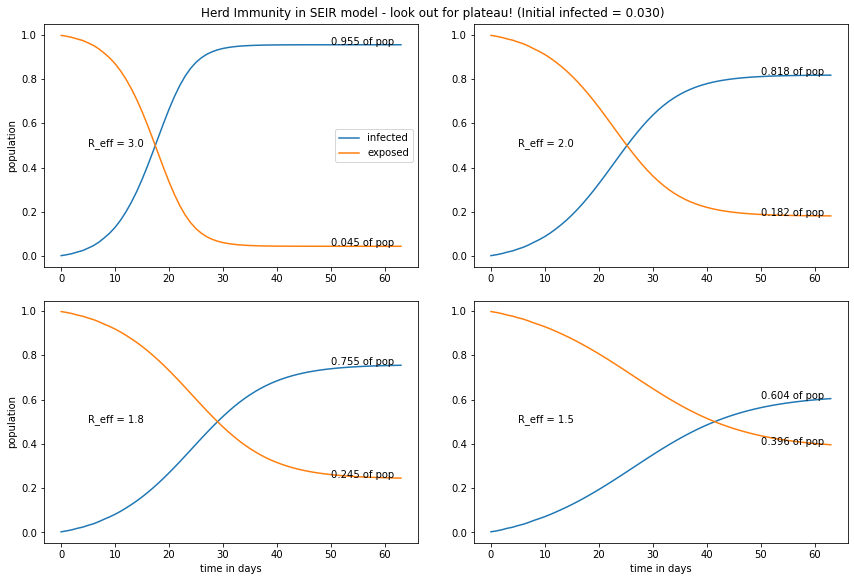

In [9]:
# Test SEIR model
median,sigma = 4.,0.433
imported_t = np.array([3e-3,4e-3,5e-3,6e-3,3e-3,4e-3,1e-3,2e-3,2e-3]+[0]*55,dtype=np.float64)

fig, axes = plt.subplots(2, 2, figsize = (12,8),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.14,left=0.05,right=0.98,top=0.95,bottom=0.05)


for i,l in enumerate([3,2,1.8,1.5]):
    lambda_t = np.array([l]*len(imported_t),dtype=np.float64)
    newI,E_t = SIER_model(1,imported_t,lambda_t,median,sigma,l=40)
    
    ax = axes[i//2,i%2]
    ax.plot(np.cumsum(newI),label="infected")
    ax.plot(E_t,label="exposed")
    ax.text(5,.5,"R_eff = %.1f"%l)
    if i == 0:
        ax.legend()
    if i%2 == 0:
        ax.set_ylabel("population")
    if i//2 == 1:
        ax.set_xlabel("time in days")
    i_end,e_end = np.cumsum(newI)[-1],E_t[-1]
    ax.text(50,i_end,"%.3f of pop"%(i_end))
    ax.text(50,e_end,"%.3f of pop"%(e_end))
        
fig.suptitle("Herd Immunity in SEIR model - look out for plateau! (Initial infected = %.3f)"%sum(imported_t))

## SIER Model with deaths and hospitalization
Uses convolution to delay the new_infected to generate deaths and hospitalization

In [51]:
# sequences (if any), prior result(s) (if needed), non-sequences (if any)
import theano.tensor.signal.conv as tt_conv
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing" # not neede in actual model, but I can't find my but at the moment

d = tt.dvector()
s_median_incubation = tt.dscalar()
s_sigma_incubation = tt.dscalar()

s_beta = tt_lognormal(d, tt.log(s_median_incubation), s_sigma_incubation)
f_beta = theano.function([d,s_median_incubation,s_sigma_incubation],[s_beta])

def theano_convolve_inputrotation(inp,filt,amplitude=1,offset=0):
    """ convolves inp with filter,
        scales by amplitude,
        additional offset in positions
      --> ouput vector has length 2*inp+filt """
    # Symbolic variables for theano
    o = tt.scalar('o',dtype='int64')
    a = tt.matrix('a',dtype='float64')
    b = tt.matrix('b',dtype='float64')
    s = tt.scalar('s',dtype='float64')
    
    # Enlarge the input in order to accomodate an offset
    zero = tt.zeros_like(a)
    a0 = tt.concatenate((a,zero,),1)
    a0r = tt.roll(a0,o,1) # delay the input signal by offset
    a0rp = tt.set_subtensor(a0r[0,:o],0) * s # set front of enlarged input_vector to zero to prevent roll overspill at front
    
    # Convolve enlarged,delayed input with filter
    func = tt.signal.conv.conv2d(a0rp,b,(1,inp.shape[0]*2),(1,filt.shape[0]),border_mode='full')
    # Bild a function
    return theano.function([a,b,s,o],func)(inp[None,:],filt[None,:],amplitude,offset)

def SEIR_model_deaths(N, imported_t,lambda_t,median_incubation,sigma_incubation,l=16):
    N = tt.cast(N,'float64')
    beta = f_beta(range(l),median_incubation,sigma_incubation)[0]
    print(beta)
    
    s_imported_t = tt.vector()
    s_lambda_t = tt.vector()
    s_infected_t = tt.vector()
    p_infected = tt.dvector("internal state")
    

    def imported_day_acc(lambda_at_t,imported_at_t,p_infected,N_at_t,beta,N):
        f = N_at_t / N
        new = imported_at_t + theano.dot(p_infected,beta) * lambda_at_t * f
        p_infected = tt.roll(p_infected,1,0)
        p_infected = tt.set_subtensor(p_infected[:1],new)
        return new,p_infected,N_at_t-new
    
    outputs_info = [None,np.zeros(l),N]
    infected_t,updates = theano.scan(fn=imported_day_acc,
                                     sequences=[s_lambda_t,s_imported_t],
                                     outputs_info=outputs_info,
                                     non_sequences=[beta,N])
    calc_infected = theano.function(inputs=[s_lambda_t,s_imported_t],outputs=infected_t,updates=updates)
    newI,I,N = calc_infected(lambda_t,imported_t)
    
    # To achieve different delays, update either the distribution bd,bh or the offset in theano_convolve
    r = np.arange(32)
    bd = f_beta(r,15,.2)[0] # Generate lognormal delay-functions
    bh = f_beta(r,10,.3)[0]
    # Delay newI through convolution to generate new hospitalization and new deaths
    newH = theano_convolve_inputrotation(newI,bh,.20,2)[0]
    newD = theano_convolve_inputrotation(newI,bd,.10,4)[0]
    
    return newI,newD,newH

NameError: name 'tt_lognormal' is not defined

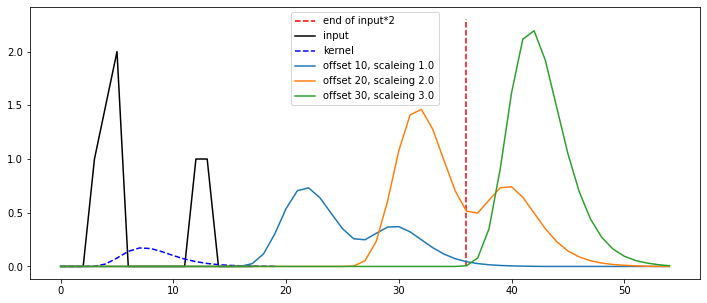

In [14]:
# Test of convolution with scaling
a = np.array([0,0,0,1,1.5,2,0,0,0,0,0,0,1,1,0,0,0,0],dtype=np.float64)
k = f_beta(np.arange(20,dtype=np.float64),8,.3)[0]

fig, axes = plt.subplots(1, 1, figsize = (12,5),squeeze=False)
ax = axes[0,0]

ax.plot([len(a)*2]*2,[0,2.3],"--",label="end of input*2",c="red")
ax.plot(a,label="input",c="black")
ax.plot(k,"--",label="kernel",c="blue")
for i,o in enumerate([10,20,30]):
    ax.plot(theano_convolve_inputrotation(a,k,i+1,o)[0],label="offset %d, scaleing %.1f"%(o,i+1) )
ax.legend()

# Note the second green peak is missing, as it was rotated out of the input-window by the offset

[0.00000000e+00 5.47896475e-03 1.27947319e-01 2.46343726e-01
 2.30385647e-01 1.61389684e-01 9.90731624e-02 5.71094898e-02
 3.19868297e-02 1.77272090e-02 9.82008058e-03 5.46900411e-03
 3.07228919e-03 1.74416399e-03 1.00164065e-03 5.82140254e-04
 3.42435297e-04 2.03852752e-04 1.22782570e-04 7.47996383e-05
 4.60729351e-05 2.86818357e-05 1.80389080e-05 1.14573449e-05
 7.34614858e-06 4.75306733e-06 3.10219690e-06 2.04171481e-06
 1.35458778e-06 9.05666877e-07 6.10026566e-07 4.13832118e-07]


Text(0, 0.5, 'number of cases')

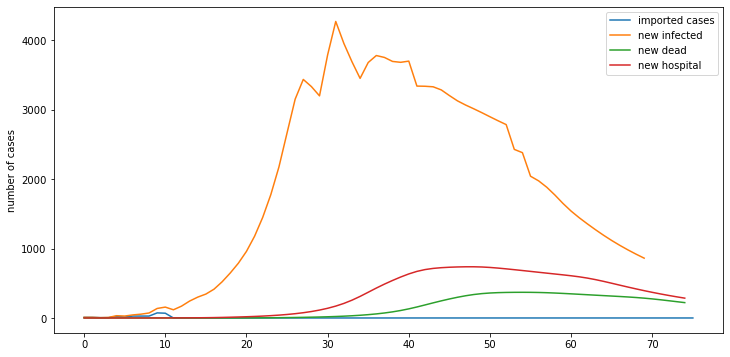

In [15]:
# Test of SEIR Model with deaths and hospitalization
initial_obs = [9.14492754,9.14492754,4.57246377,4.57246377,22.86231884,13.7173913,27.43478261,27.43478261,27.43478261,
               73.15942029,68.58695652,0.]
imported_cases = np.asarray(initial_obs+[0]*64)

# Test-lambda
lambda_t = np.array( ([2.8]*26+[2.7,2.4,1.9]+[1.5]*3+[1.3,1.15]+[1]*7+[.9]*12+[.8,.8]+[.7]*15)[:len(imported_cases)] ,dtype=np.float32)

data = SEIR_model_deaths(86e6,imported_cases,lambda_t,4,.433,l=32)
newI,newD,newH = data

fig, axes = plt.subplots(1, 1, figsize = (12,6),squeeze=False)
ax = axes[0,0]

end = 75
ax.plot(imported_cases,label="imported cases")
ax.plot(newI[:end],label="new infected")
ax.plot(newD[:end],label="new dead")
ax.plot(newH[:end],label="new hospital")
ax.legend()
ax.set_ylabel("number of cases")


## Weekly (Random Walk) interpolation
take a vector of per_week values and generate a daily sequence with smoothing 

In [3]:
import theano.tensor.signal.conv as tt_conv

def Weekinterpolation(w_values,kernel):
#    w = tt.iscalar()
    val = tt.dvector()
    kern = tt.dvector()
    kern = kern / tt.sum(kern)
    
    lval = tt.alloc(0.,val.shape[0]+2)
    lval = tt.cast(lval,"float64")
    lval = tt.set_subtensor(lval[1:-1],val)
    lval = tt.set_subtensor(lval[0],val[0])
    lval = tt.set_subtensor(lval[-1],val[-1])
    
    m = tt.alloc(lval,7,lval.shape[0])
    mf = tt.flatten(m.T,ndim=1)
    
    mf2 = tt.alloc(mf,1,mf.shape[0])
    kern2 = tt.alloc(kern,1,kern.shape[0])
    
    r = tt.signal.conv.conv2d(mf2,kern2,border_mode='full')
    rs = r[0,(7+kernel.shape[0]//2):(7*val.shape[0]+7+kernel.shape[0]//2)]
    
    return theano.function([val,kern],rs)(w_values,kernel)

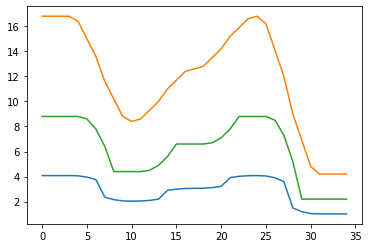

In [37]:
x = np.array([4,2,3,4,1],dtype=np.float64)
k1 = np.array([.01,.05,.1,.7,.1,.05,.01])
k2 = np.array([.2,.7,.7,1,.7,.7,.2],dtype=np.float64)
k3 = np.array([.1,.4,.7,1.],dtype=np.float64)

r1 = Weekinterpolation(x,k1)
r2 = Weekinterpolation(x,k2)
r3 = Weekinterpolation(x,k3)

plt.plot(r1)
plt.plot(r2)
plt.plot(r3)

In [ ]:
def WeekinterpolationWithWeekendEffekt(w_values,kernel,):
    """ rotate so that changepoint is monday
    + Weekend - modifier
    + Calculate weeks*days matrix
    Mo Di Mi ... So Mo Di ...
    1  0    ...   0  1  0  
    0  1  0    ...   0  1
    0  0  1     .....
    """
    
    
#    w = tt.iscalar()
    val = tt.dvector()
    kern = tt.dvector()
    kern = kern / tt.sum(kern)
    
    lval = tt.alloc(0.,val.shape[0]+2)
    lval = tt.cast(lval,"float64")
    lval = tt.set_subtensor(lval[1:-1],val)
    lval = tt.set_subtensor(lval[0],val[0])
    lval = tt.set_subtensor(lval[-1],val[-1])
    
    m = tt.alloc(lval,7,lval.shape[0])
    mf = tt.flatten(m.T,ndim=1)
    
    mf2 = tt.alloc(mf,1,mf.shape[0])
    kern2 = tt.alloc(kern,1,kern.shape[0])
    
    r = tt.signal.conv.conv2d(mf2,kern2,border_mode='full')
    rs = r[0,(7+kernel.shape[0]//2):(7*val.shape[0]+7+kernel.shape[0]//2)]
    
    return theano.function([val,kern],rs)(w_values,kernel)